In [3]:
# CSV is at goodreads_ratings/goodreads_ratings.csv

import pandas as pd
import numpy as np
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load the ratings data
ratings_df = pd.read_csv('./goodreads_ratings/goodreads_ratings.csv')

# Basic info
print("Dataset shape:", ratings_df.shape)
print("\nColumn info:")
ratings_df.info()

# Check value distributions
print("\nRatings distribution:")
ratings_df['rating'].value_counts().sort_index()

Dataset shape: (5976479, 4)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 4 columns):
 #   Column      Dtype
---  ------      -----
 0   Unnamed: 0  int64
 1   user_id     int64
 2   book_id     int64
 3   rating      int64
dtypes: int64(4)
memory usage: 182.4 MB

Ratings distribution:


rating
1     124195
2     359257
3    1370916
4    2139018
5    1983093
Name: count, dtype: int64

Number of unique users: 53424
Number of unique books: 10000
Average ratings per user: 111.86880428271938
Average ratings per book: 597.6479


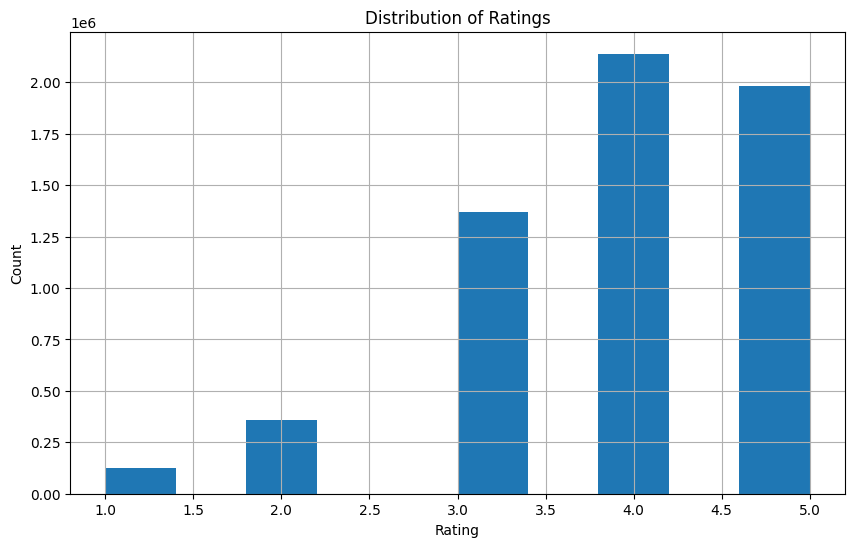

In [4]:
# Basic statistics
print("Number of unique users:", ratings_df['user_id'].nunique())
print("Number of unique books:", ratings_df['book_id'].nunique())
print("Average ratings per user:", len(ratings_df) / ratings_df['user_id'].nunique())
print("Average ratings per book:", len(ratings_df) / ratings_df['book_id'].nunique())

# Plot rating distribution
plt.figure(figsize=(10, 6))
ratings_df['rating'].hist(bins=10)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


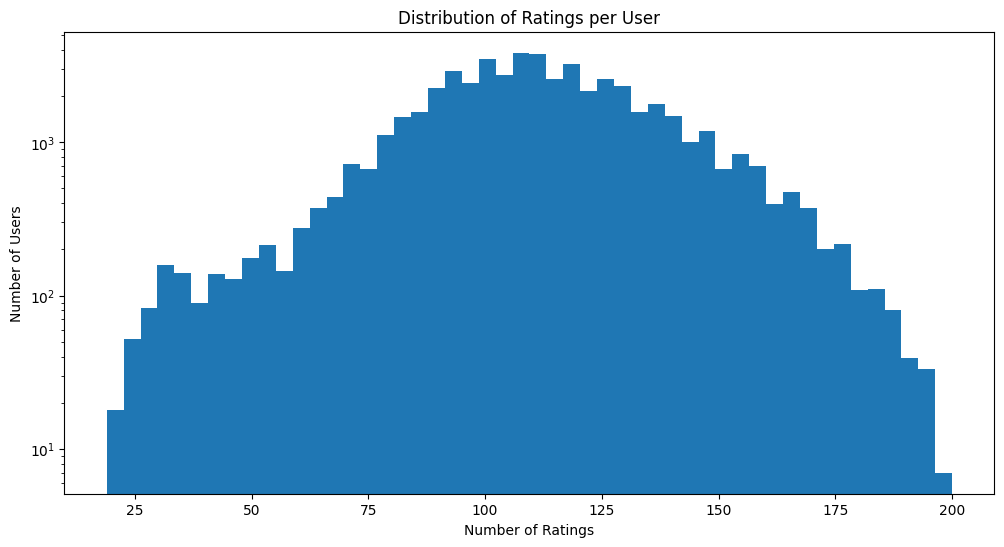


User rating statistics:
count    53424.000000
mean       111.868804
std         26.071224
min         19.000000
25%         96.000000
50%        111.000000
75%        128.000000
max        200.000000
Name: count, dtype: float64


In [5]:
# Check distribution of ratings per user
user_ratings = ratings_df['user_id'].value_counts()

plt.figure(figsize=(12, 6))
plt.hist(user_ratings, bins=50)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.yscale('log')  # Log scale for better visualization
plt.show()

print("\nUser rating statistics:")
print(user_ratings.describe())

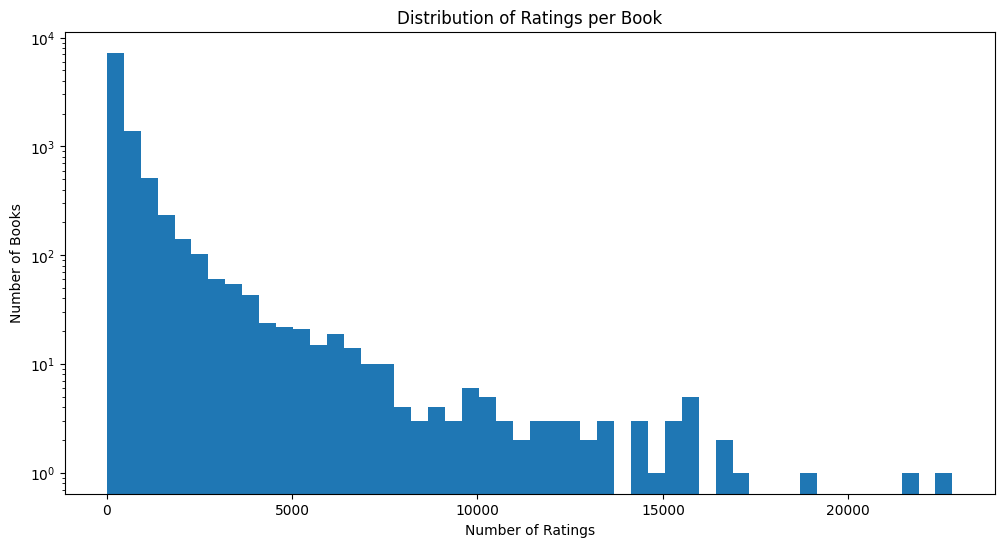


Book rating statistics:
count    10000.000000
mean       597.647900
std       1267.289788
min          8.000000
25%        155.000000
50%        248.000000
75%        503.000000
max      22806.000000
Name: count, dtype: float64


In [6]:
# Check distribution of ratings per book
book_ratings = ratings_df['book_id'].value_counts()

plt.figure(figsize=(12, 6))
plt.hist(book_ratings, bins=50)
plt.title('Distribution of Ratings per Book')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Books')
plt.yscale('log')
plt.show()

print("\nBook rating statistics:")
print(book_ratings.describe())

In [29]:
# Load books metadata with Goodreads IDs
books_df = pd.read_csv('./goodreads_ratings/goodreads_books.csv')

# Create mapping dictionary
book_mapping = pd.Series(
    books_df.goodreads_book_id.values,
    index=books_df.book_id
).to_dict()

# Add reverse mapping
goodreads_to_dataset = {v: k for k, v in book_mapping.items()}

print("Number of mapped books:", len(book_mapping))
print("\nSample mappings:")
for i, (dataset_id, goodreads_id) in enumerate(list(book_mapping.items())[:5]):
    book_info = books_df[books_df['book_id'] == dataset_id].iloc[0]
    print(f"Dataset ID: {dataset_id} → Goodreads ID: {goodreads_id}")
    print(f"Title: {book_info['title']} by {book_info['authors']}\n")

Number of mapped books: 10000

Sample mappings:
Dataset ID: 1 → Goodreads ID: 2767052
Title: The Hunger Games (The Hunger Games, #1) by Suzanne Collins

Dataset ID: 2 → Goodreads ID: 3
Title: Harry Potter and the Sorcerer's Stone (Harry Potter, #1) by J.K. Rowling, Mary GrandPré

Dataset ID: 3 → Goodreads ID: 41865
Title: Twilight (Twilight, #1) by Stephenie Meyer

Dataset ID: 4 → Goodreads ID: 2657
Title: To Kill a Mockingbird by Harper Lee

Dataset ID: 5 → Goodreads ID: 4671
Title: The Great Gatsby by F. Scott Fitzgerald



In [8]:
# Set minimum thresholds
MIN_BOOK_RATINGS = 100
MIN_USER_RATINGS = 15

# Filter out rarely rated books and inactive users
filtered_books = book_ratings[book_ratings >= MIN_BOOK_RATINGS].index
filtered_users = user_ratings[user_ratings >= MIN_USER_RATINGS].index

filtered_df = ratings_df[
    ratings_df['book_id'].isin(filtered_books) & 
    ratings_df['user_id'].isin(filtered_users)
]

print("Original ratings shape:", ratings_df.shape)
print("Filtered ratings shape:", filtered_df.shape)

Original ratings shape: (5976479, 4)
Filtered ratings shape: (5935973, 4)


In [14]:
# Create user and book ID mappings (needed because IDs might not be sequential)

user_id_map = {id: i for i, id in enumerate(filtered_df['user_id'].unique())}
book_id_map = {id: i for i, id in enumerate(filtered_df['book_id'].unique())}

# Convert to sparse matrix format
rows = filtered_df['user_id'].map(user_id_map)
cols = filtered_df['book_id'].map(book_id_map)
ratings = filtered_df['rating'].astype(np.float32)

# Create sparse matrix (users x books)
sparse_ratings = csr_matrix(
    (ratings, (rows, cols)),
    shape=(len(user_id_map), len(book_id_map))
)

print("Sparse matrix shape:", sparse_ratings.shape)
print("Matrix density:", sparse_ratings.nnz / (sparse_ratings.shape[0] * sparse_ratings.shape[1]) * 100, "%")

Sparse matrix shape: (53424, 9511)
Matrix density: 1.1682326329542163 %


In [30]:
# Initialize ALS model
model = AlternatingLeastSquares(
    factors=100,       # number of latent factors
    regularization=0.1,
    iterations=15,     
    random_state=42
)

# Train the model
print("Training ALS model...")
model.fit(sparse_ratings)

# Save model and mappings
import joblib

model_data = {
    'model': model,
    'user_id_map': user_id_map,
    'book_id_map': book_id_map,
    'inverse_user_map': {v: k for k, v in user_id_map.items()},
    'inverse_book_map': {v: k for k, v in book_id_map.items()},
    'goodreads_book_map': book_mapping,
    'dataset_book_map': goodreads_to_dataset
}

joblib.dump(model_data, 'goodreads_collaborative_model.joblib')
print("Model saved with Goodreads ID mappings!")

Training ALS model...


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


Model saved with Goodreads ID mappings!


In [39]:
# Get recommendations for a random user
test_user_id = list(user_id_map.keys())[0]
user_idx = user_id_map[test_user_id]

# Get top 5 recommendations
book_ids, scores = model.recommend(user_idx, sparse_ratings[user_idx], N=5)

print(f"Top 5 recommendations for user {test_user_id}:")
for book_idx, score in zip(book_ids, scores):
    original_book_id = model_data['inverse_book_map'][book_idx]
    # print(f"Book ID: {original_book_id},  Score: {score:.2f}")
    goodreads_book_id = model_data['goodreads_book_map'].get(original_book_id, None)
    goodreads_book_title = books_df[books_df['book_id'] == original_book_id]['title'].values[0]
    goodreads_book_id = goodreads_book_id if goodreads_book_id else "N/A"
    print(f"Title: {goodreads_book_title}, Score: {score:.2f}")

Top 5 recommendations for user 1:
Title: Anna Karenina, Score: 1.18
Title: Cutting for Stone, Score: 0.97
Title: Wuthering Heights, Score: 0.93
Title: The Guernsey Literary and Potato Peel Pie Society, Score: 0.90
Title: The Little Prince, Score: 0.84
